<a href="https://colab.research.google.com/github/bhanuprasadtudy/advancedadvertisingstatistics/blob/master/Trends_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import datetime
import pandas as pd

In [3]:
try:
  import pytrends
except ModuleNotFoundError:
  !pip install pytrends
  import pytrends 
from pytrends.request import TrendReq

  Created wheel for pytrends: filename=pytrends-4.7.2-cp36-none-any.whl size=14261 sha256=8d4e94fd2afa19e8e681ed108de433d4c8725546d5f07cbff0be2352e1499dd0
  Stored in directory: /root/.cache/pip/wheels/64/ae/af/51d48fbbca0563036c6f80999b7ce3f097fa591fd165047baf
Successfully built pytrends


In [4]:
try:
  import ratelimiter
except ModuleNotFoundError:
  !pip install ratelimiter
  import ratelimiter
from ratelimiter import RateLimiter

# Trend Fetcher
 
 Define a rate-limited function for fetching trend data from Google
 

In [0]:
pt = TrendReq(
    tz=0,
    timeout=(10,25),
    retries=2,
    backoff_factor=0.1)
@RateLimiter(max_calls=1, period=10)
def fetch_trends(keywords, start_date, end_date, sleep=0):
    """Experimentally, it seems that we can get 13 days of hourly data in a
    single request. pytrends does not log out its progress, so rather than
    depending on the library to manage rate-limiting, it is recommended to
    fetch and log 13-day batches and to manage the rate limit explicitly.
    However, the 13-day limit is not enforced by this function. If you need
    to rate-limit pytrends internally, pass in the optional sleep parameter.
    Note: The rate limit is not explicitly stated by Google. See the pytrends
    docs for more information about rate limiting.
    
    1 year of data on a single keyword is 365 / 13 = 28 requests. This keeps us
    well under the empirically documented 1400 sequential requests before
    throttling. However, this is Google ... we should be extremely conservative.
    At a 10 second/request limit, we can fetch 1 year for a keyword in about
    5 minutes.
    Returns a Pandas dataframe.
    """
    return pt.get_historical_interest(
        keywords,
        year_start=start_date.year,
        month_start=start_date.month,
        day_start=start_date.day,
        hour_start=0,
        year_end=end_date.year,
        month_end=end_date.month,
        day_end=end_date.day,
        hour_end=23,
        cat=0,
        geo='',
        gprop='',
        sleep=sleep)

# Data Specific Values
set these according to your dataset
See the fetch_trends documentation above for info about batch_size

In [0]:
KEYWORDS =['/m/01b566'] #chipotle
BATCH_SIZE = 13
START_DATE = datetime.date(2020,2,13) 
END_DATE = datetime.date(2020,3,14)

# FETCH THE DATA

In [7]:
keywords = KEYWORDS
# overshoot the end date by BATCH_SIZE to be sure we get everything
end_date = END_DATE + datetime.timedelta(days=BATCH_SIZE)
data = None
batch_start_date = START_DATE
while batch_start_date <= end_date:
    print(batch_start_date)
    batch_end_date = batch_start_date + datetime.timedelta(days=BATCH_SIZE)
    trends = fetch_trends(keywords, batch_start_date, batch_end_date)
    if data is None:
        data = trends
    else:
        data.append(trends)
    batch_start_date += datetime.timedelta(days=14)

2020-02-13
2020-02-27
2020-03-12
2020-03-26
The request failed: Google returned a response with code 400.
The request failed: Google returned a response with code 400.


In [8]:
data

,/m/01b566,isPartial
date,,
2020-02-13 00:00:00,69,False
2020-02-13 01:00:00,68,False
2020-02-13 02:00:00,64,False
2020-02-13 03:00:00,44,False
2020-02-13 04:00:00,31,False
...,...,...
2020-02-26 19:00:00,0,False
2020-02-26 20:00:00,0,False
2020-02-26 21:00:00,0,False


# Prophet TSA

In [0]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [0]:
prophetdata= pd.DataFrame()
prophetdata['y']= data['/m/01b566']
prophetdata['ds']= data.index

In [11]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(prophetdata)
future= m.make_future_dataframe(periods=60, freq='H')
future.tail()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


,ds
392,2020-02-29 07:00:00
393,2020-02-29 08:00:00
394,2020-02-29 09:00:00
395,2020-02-29 10:00:00
396,2020-02-29 11:00:00


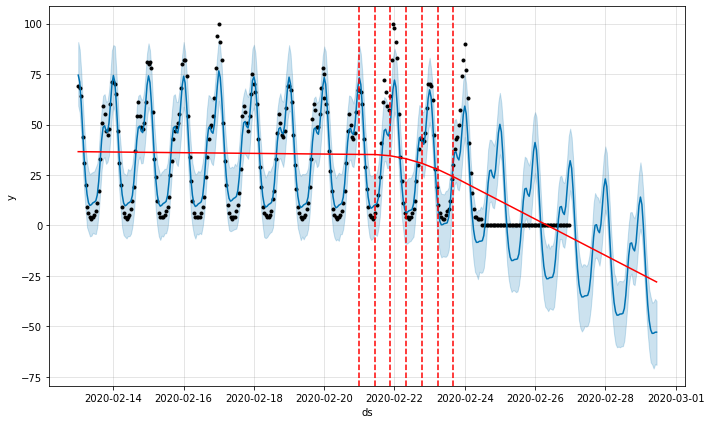

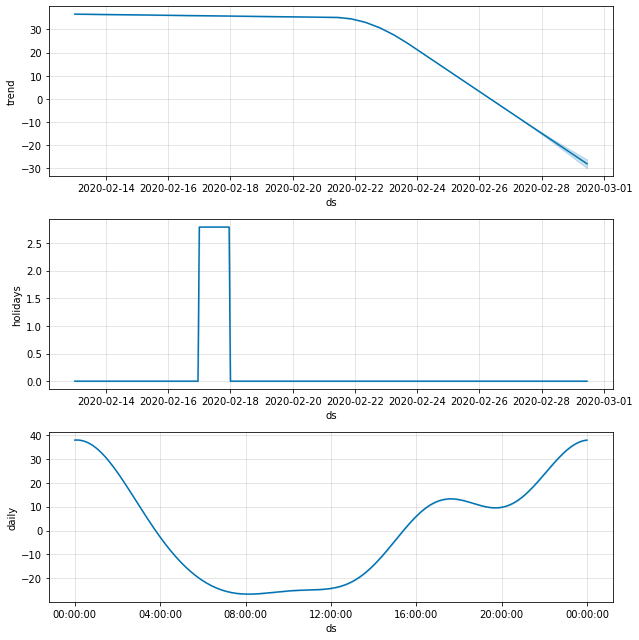

In [12]:
forecast = m.predict(future)
fig1= m.plot(forecast)
fig2 = m.plot_components(forecast)
a= add_changepoints_to_plot(fig1.gca(),m,forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


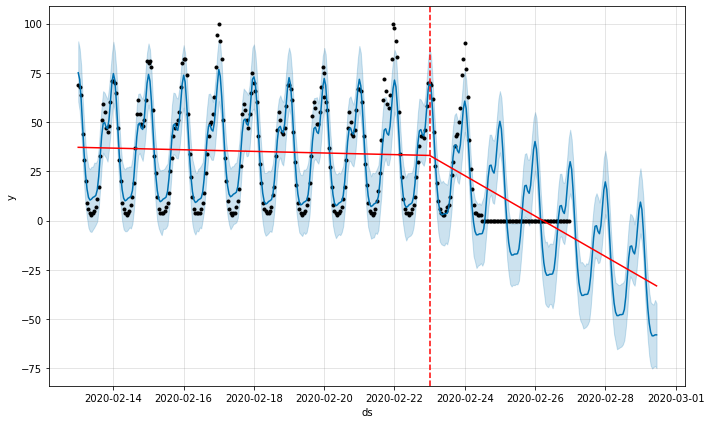

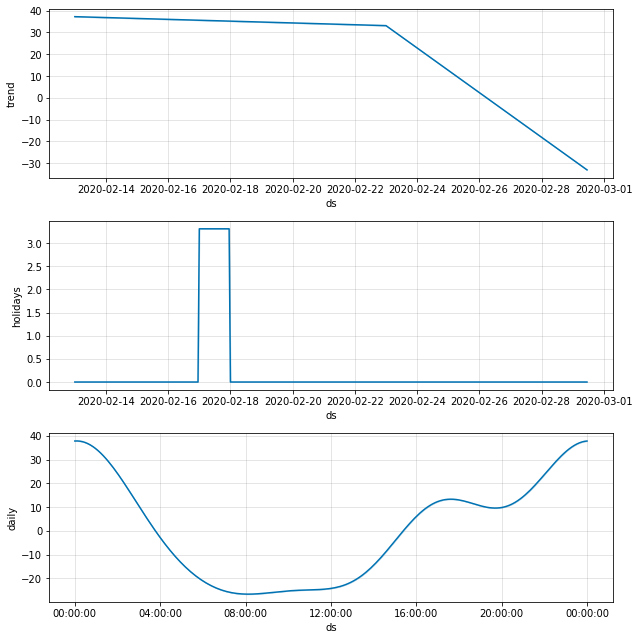

In [14]:
changepoints = ['2020-02-23']
m = Prophet(changepoints=changepoints)
m.add_country_holidays(country_name='US')
m.fit(prophetdata)
future = m.make_future_dataframe(periods=60, freq='H')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)